<a href="https://colab.research.google.com/github/Eduard25/Clasificacion-de-Galaxias-con-Filtros/blob/main/Entrenando_el_Modelo2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Red Neuronal Clasificadora de Galaxias

### En este codigo aplicamos el filtro sobel. En esta red neuronal vamos a realizar una clasificación de galaxias, vamos a utilizar una base de datos que podemos descargar mediante código.

In [2]:
## Primero instalamos astroNN que nos va a permitir descargar la base de datos de muchísimas imagenes de galaxias digitalmente
## lo cual nos ahorra mucho trabajo respecto a la base de datos
%pip install astroNN

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.4/999.4 kB 44.2 MB/s eta 0:00:00


In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Importamos las librerias que utilizaremos
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D, Dropout,Activation,MaxPooling2D,Flatten
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras import utils
import numpy as np
from sklearn.model_selection import train_test_split
import pylab as plt

from astroNN.models import Galaxy10CNN
from astroNN.datasets import load_galaxy10sdss
from astroNN.datasets.galaxy10sdss import galaxy10cls_lookup, galaxy10_confusion

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
## Para el filtro despues de estar investigando y probando los filtros que vimos en clase y nuevos filtro
## Decido quedarme con el filtro de sobel, que permite resaltar los bordes y estructuras, que puede
## ser muy util para resaltar los bordes de las galaxias, como sus brazos espirales, etc.

from scipy.ndimage import sobel

def apply_sobel_filter_rgb(images):
    sobel_images = []
    for img in images:
        sobel_img = np.stack([sobel(img[:, :, i]) for i in range(3)], axis=-1)
        sobel_images.append(sobel_img)
    return np.array(sobel_images)

In [11]:
#Descargamos la Database que se encuentra de manera digital

## Despues de varios intentos, si las imagenes de la siguiente celda de codigo no cargan bien
## Recomiendo volver a cargar esta celda de codigo, así fue como obtuve resultados exitosos
images1, labels = load_galaxy10sdss()

#Convertimos a las 10 clases que queremos clasificar nuestras galaxias
labels = utils.to_categorical(labels, 10)

# Aplicamos filtro de Sobel a todas las imágenes
images = apply_sobel_filter_rgb(images1)


/root/.astroNN/datasets/Galaxy10.h5 was found!


In [ ]:
# Las 10 categorias en las que se dividiran el dataset son:
Galaxy10 dataset (21785 images)
├── Class 0 (3461 images): Disk, Face-on, No Spiral
├── Class 1 (6997 images): Smooth, Completely round
├── Class 2 (6292 images): Smooth, in-between round
├── Class 3 (394 images): Smooth, Cigar shaped
├── Class 4 (1534 images): Disk, Edge-on, Rounded Bulge
├── Class 5 (17 images): Disk, Edge-on, Boxy Bulge
├── Class 6 (589 images): Disk, Edge-on, No Bulge
├── Class 7 (1121 images): Disk, Face-on, Tight Spiral
├── Class 8 (906 images): Disk, Face-on, Medium Spiral
└── Class 9 (519 images): Disk, Face-on, Loose Spiral

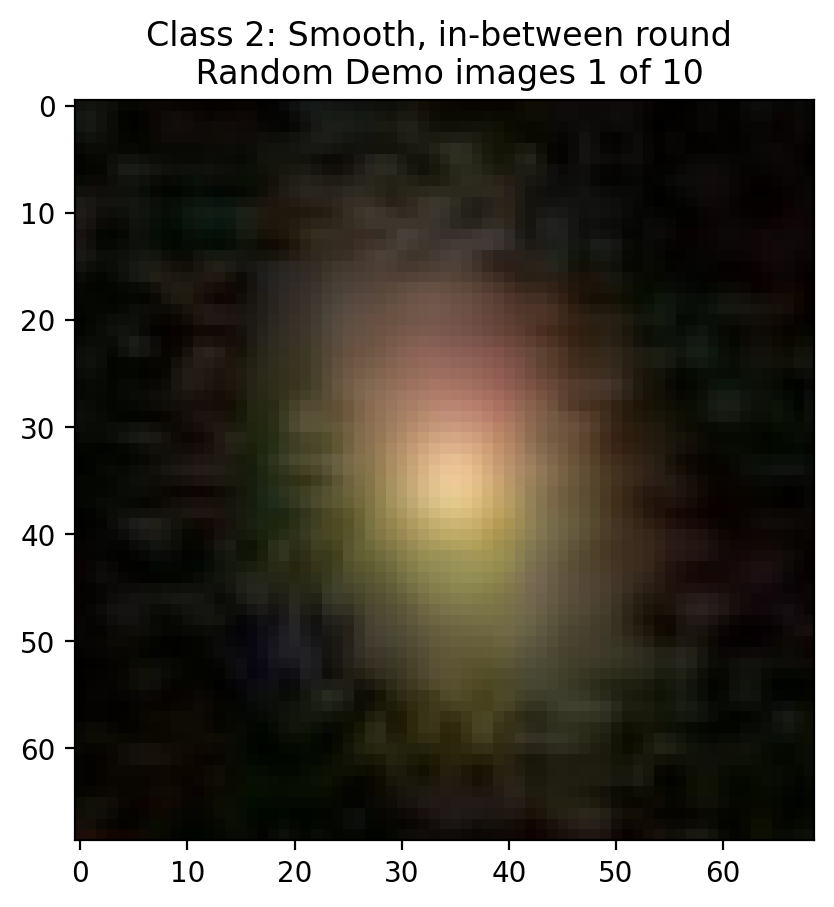

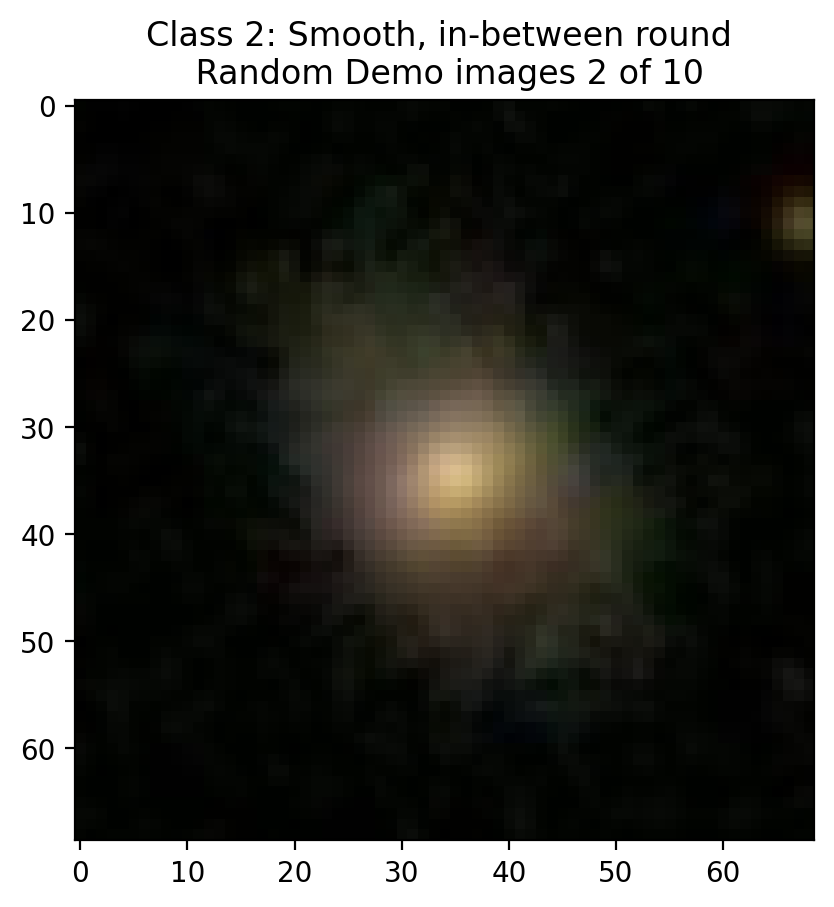

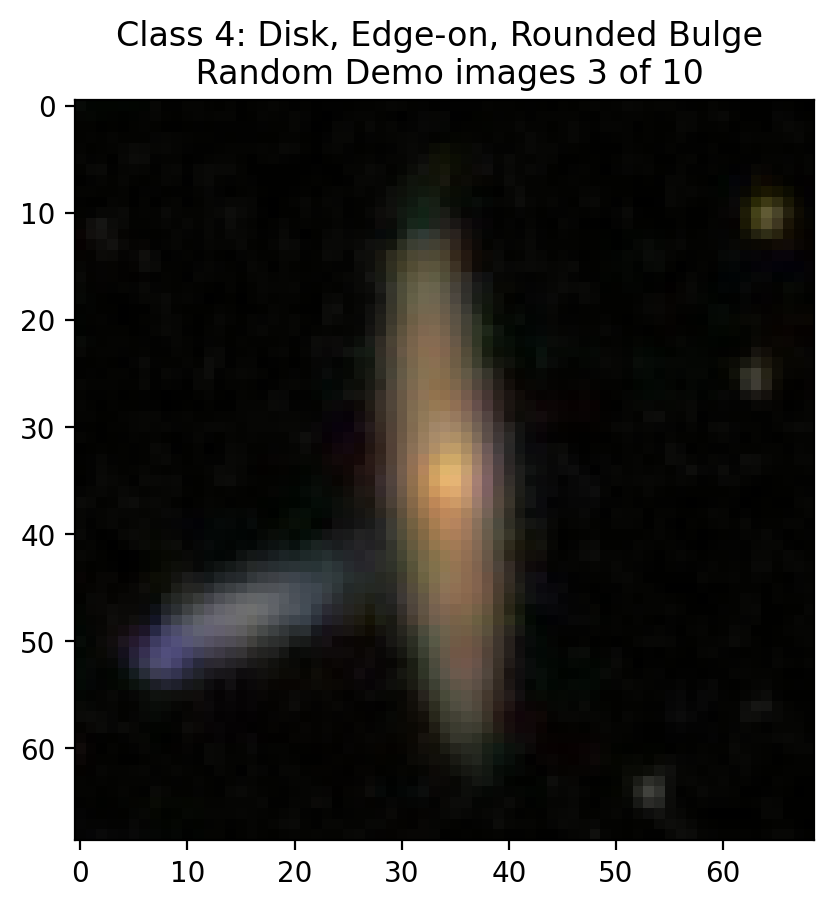

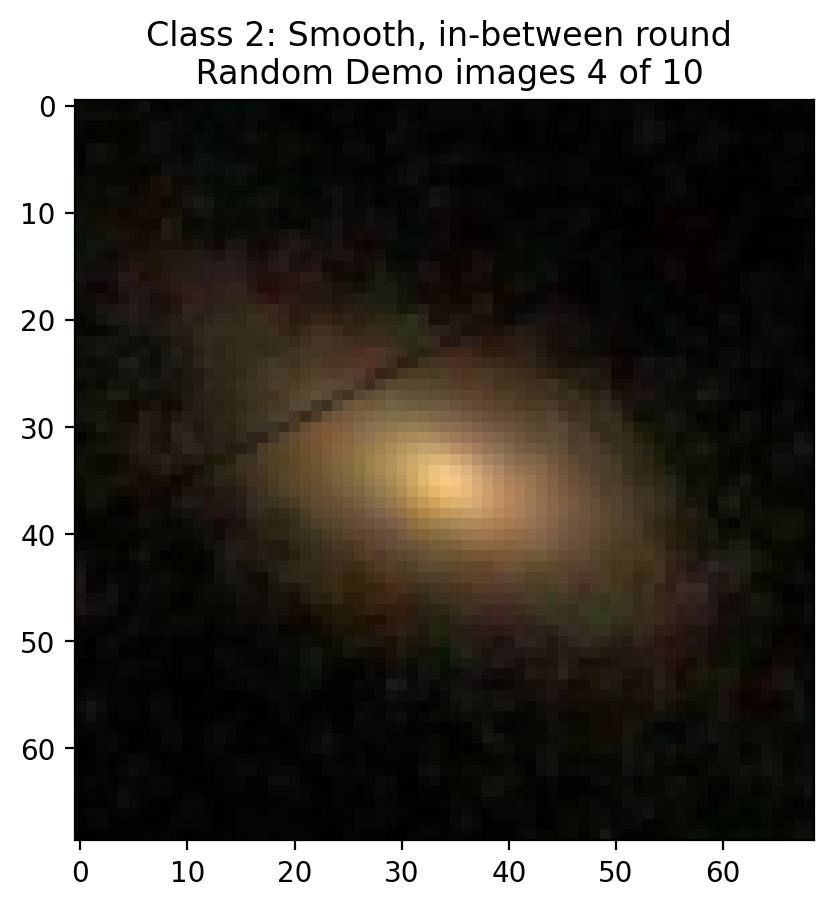

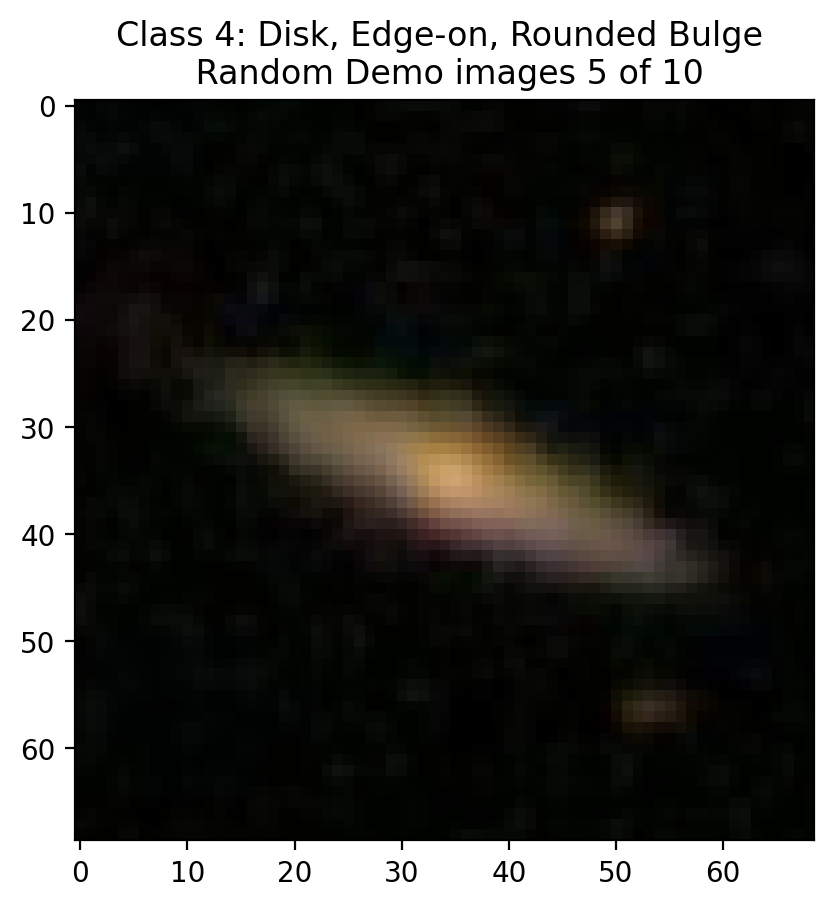

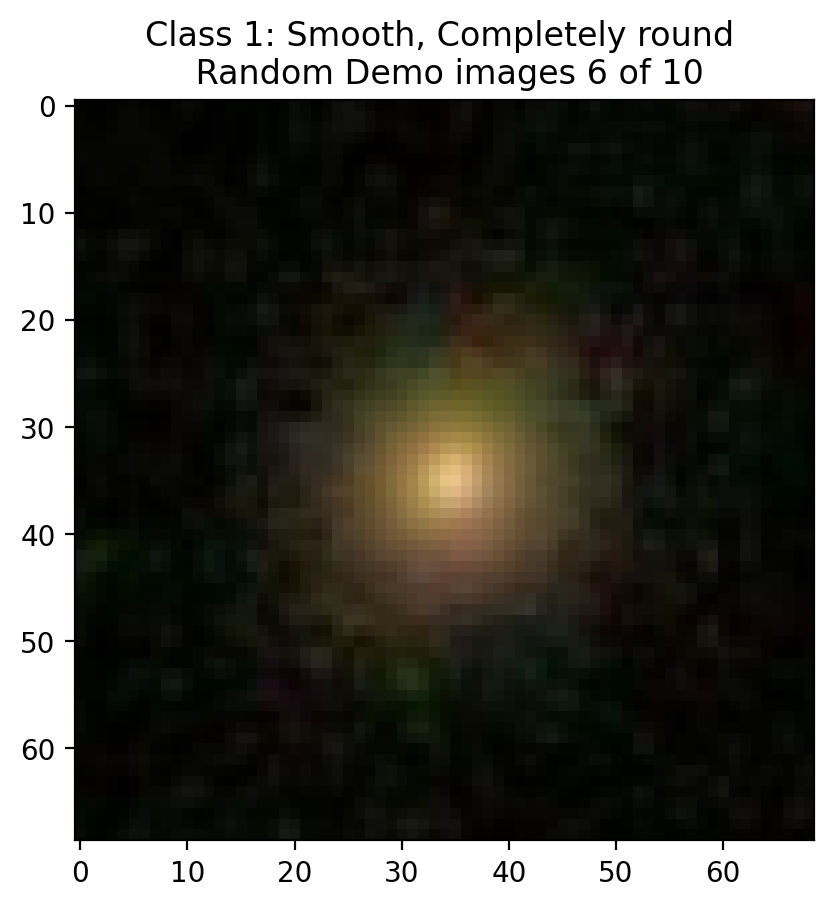

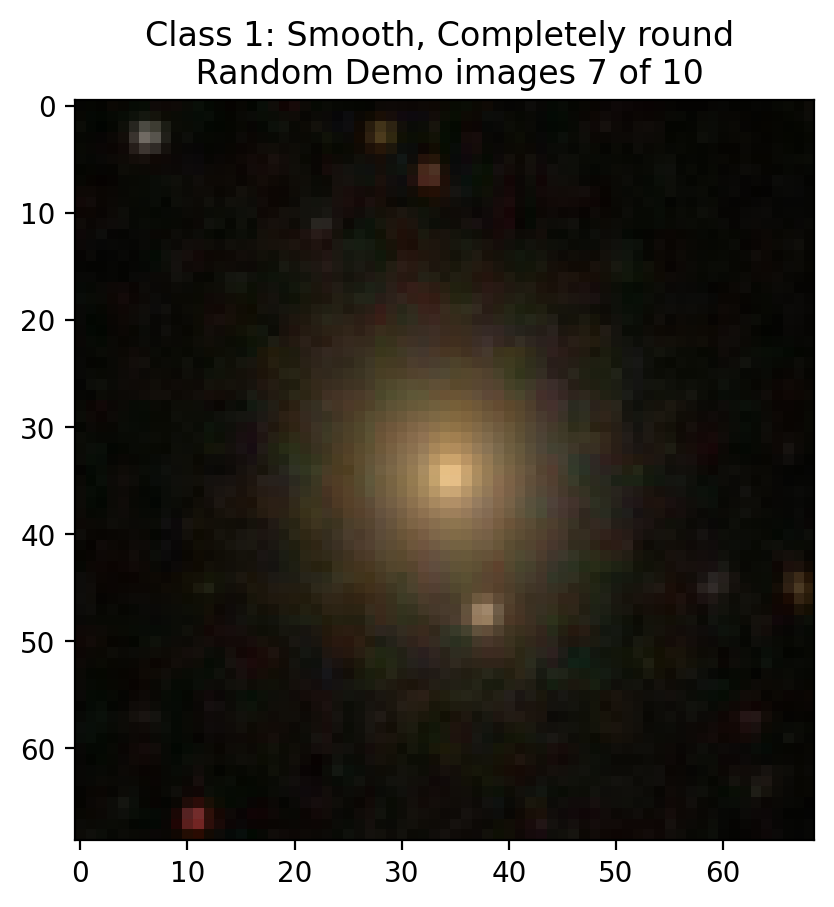

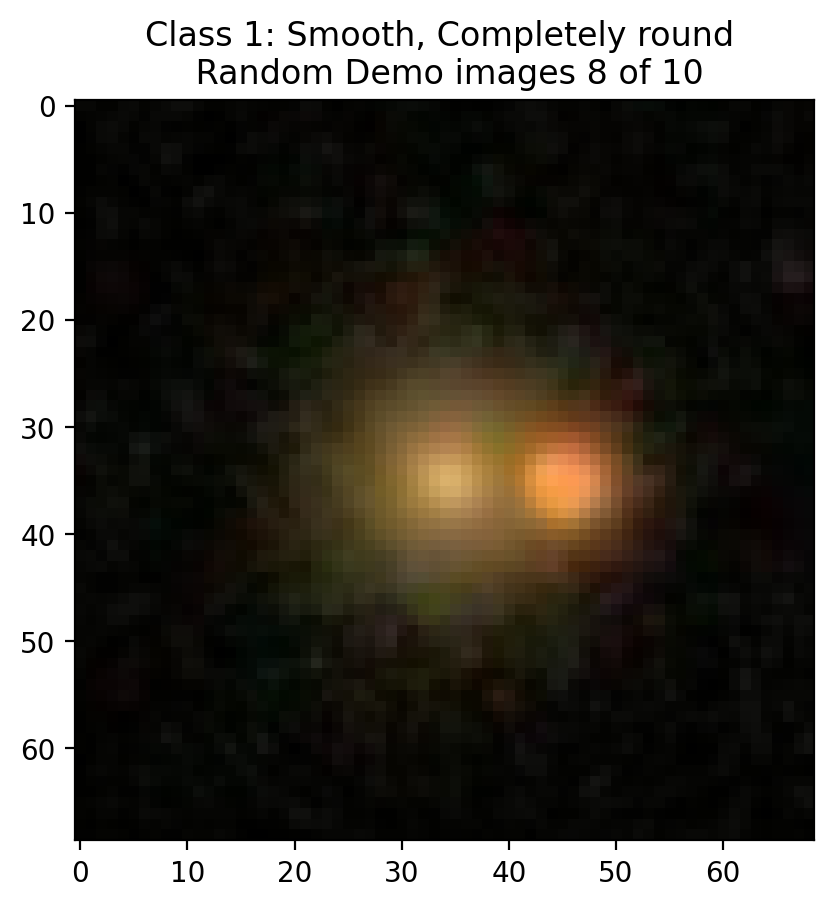

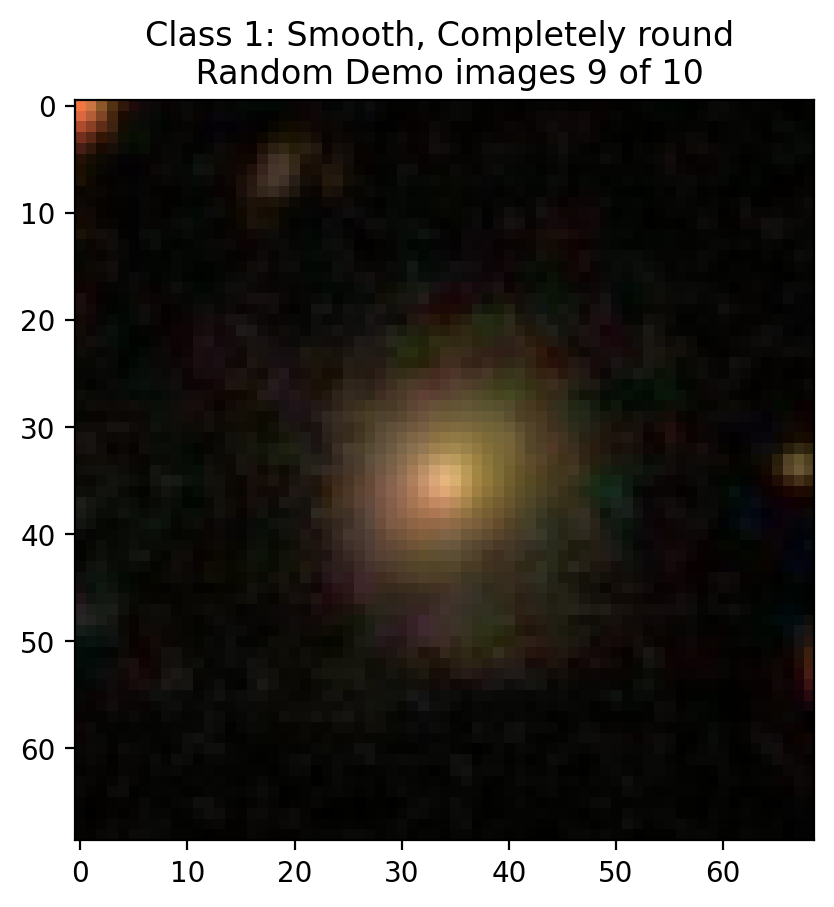

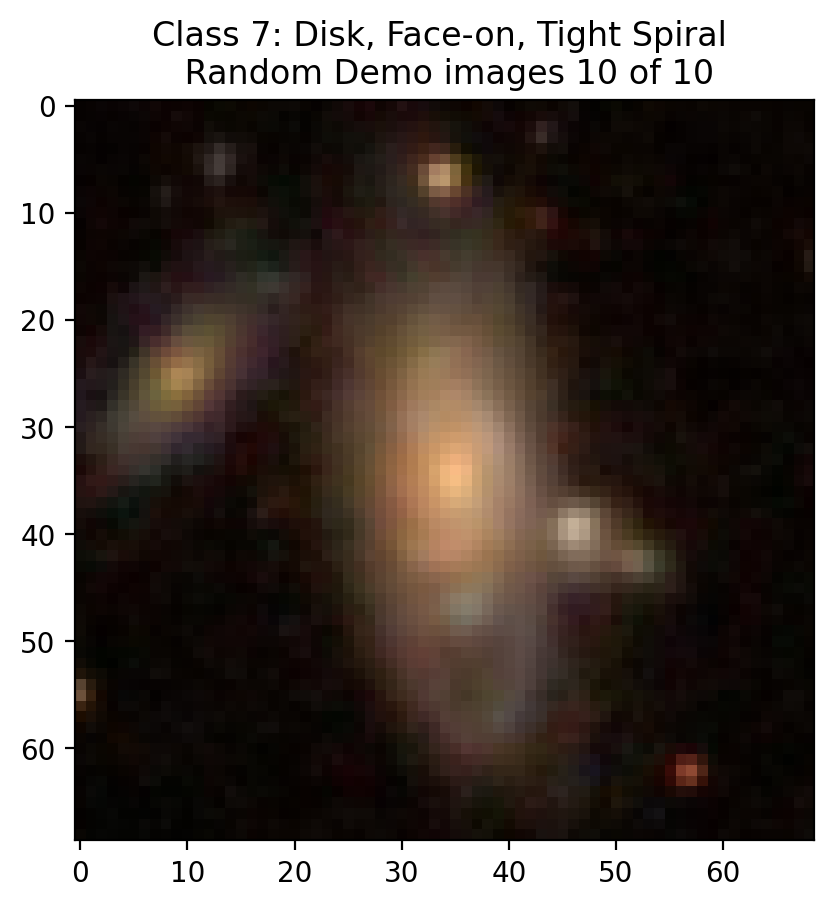

In [12]:
#Seleccionamos 10 imágenes para analizar su forma y las componentes que tienen Y VISUALIZAMOS SIN FILTRO
img = None
plt.ion()

for counter, i in enumerate(range(np.random.randint(0, labels.shape[0], size=10).shape[0])):
    img = plt.imshow(images1[i])
    plt.title(f"Class {np.argmax(labels[i])}: {galaxy10cls_lookup(labels[i])} \n Random Demo images {counter+1} of 10")
    plt.draw()
    plt.pause(2.)
plt.close("all")

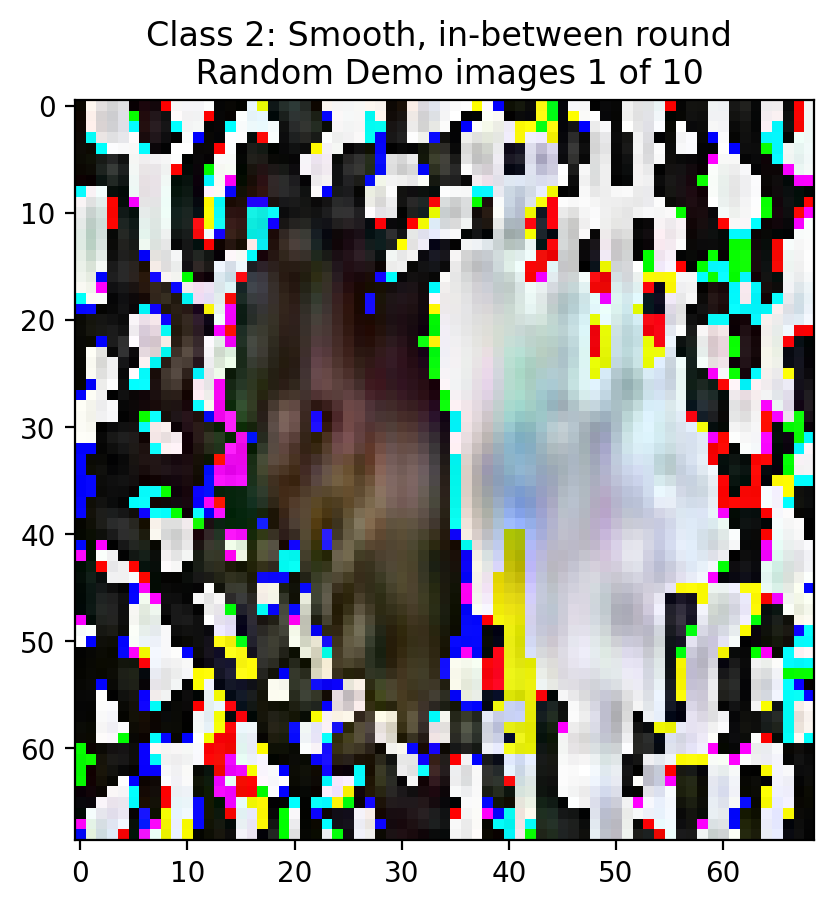

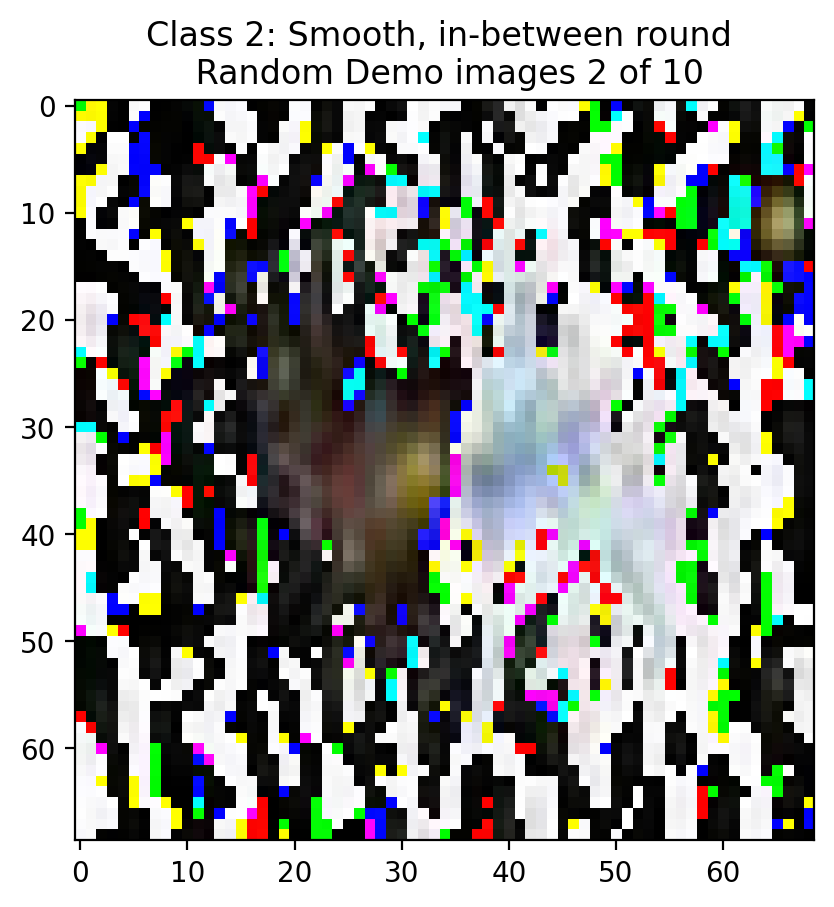

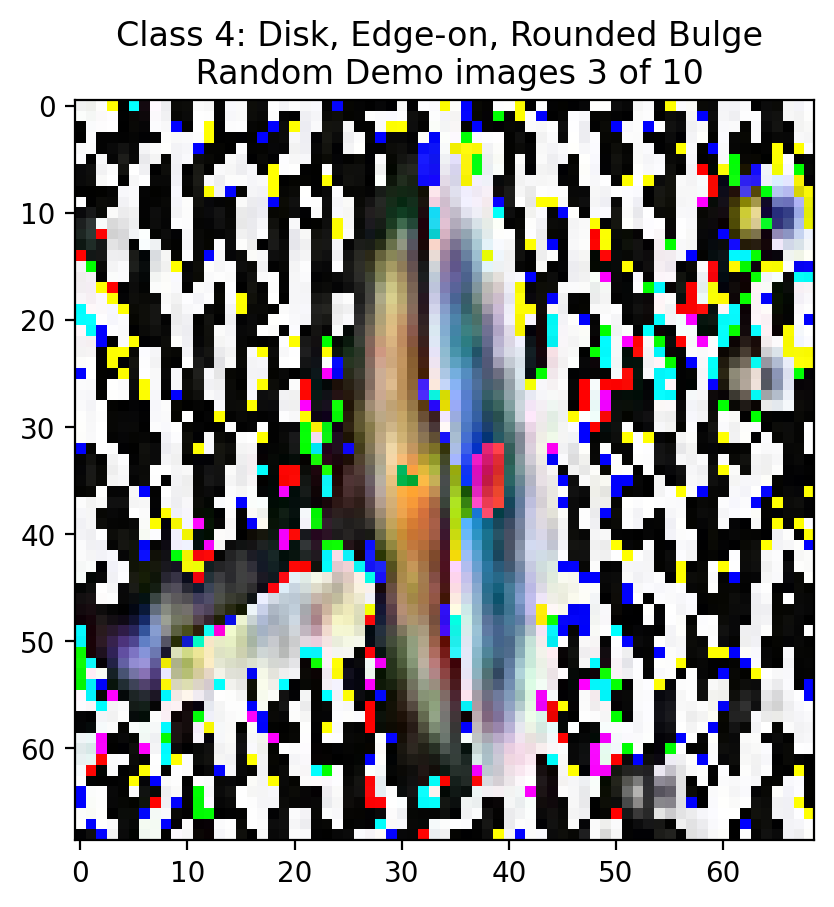

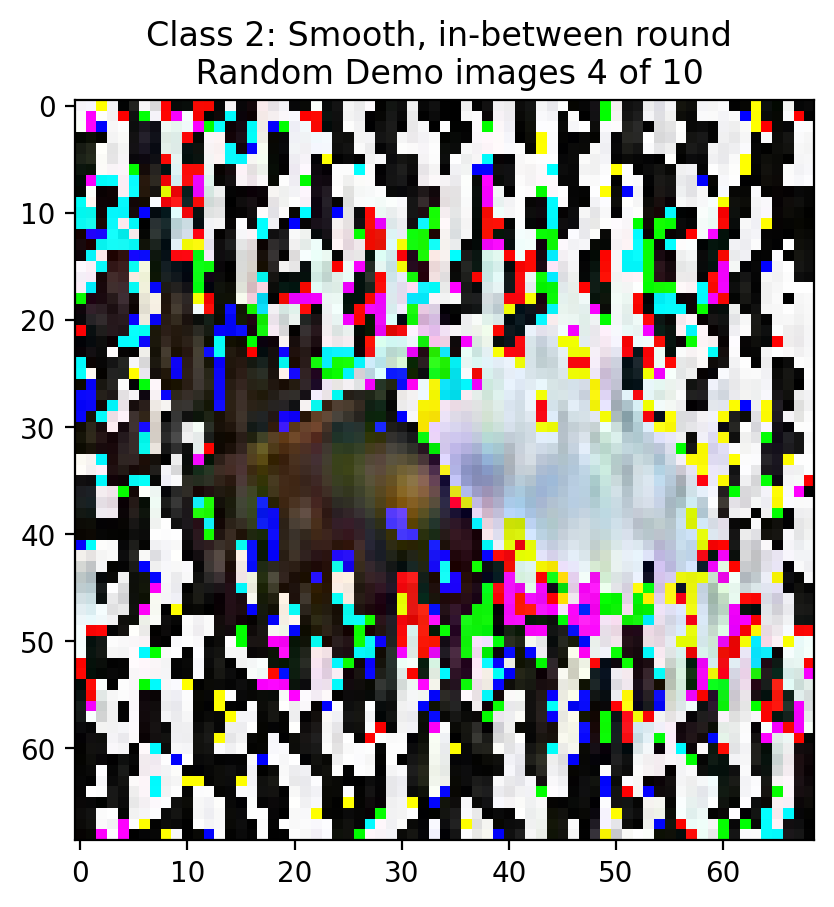

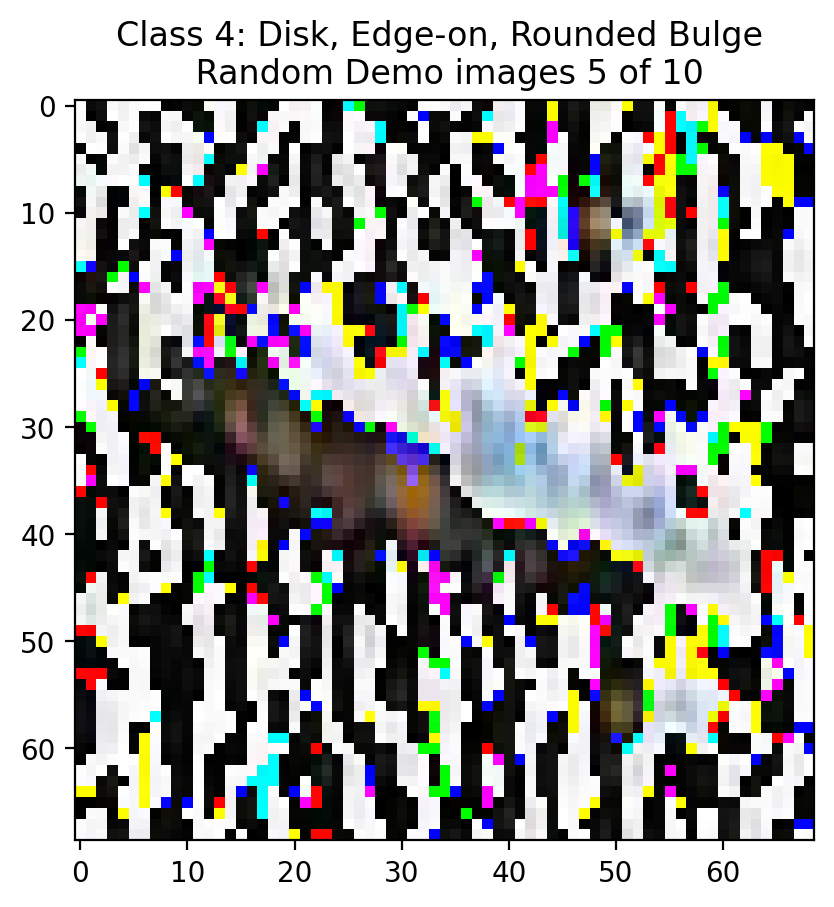

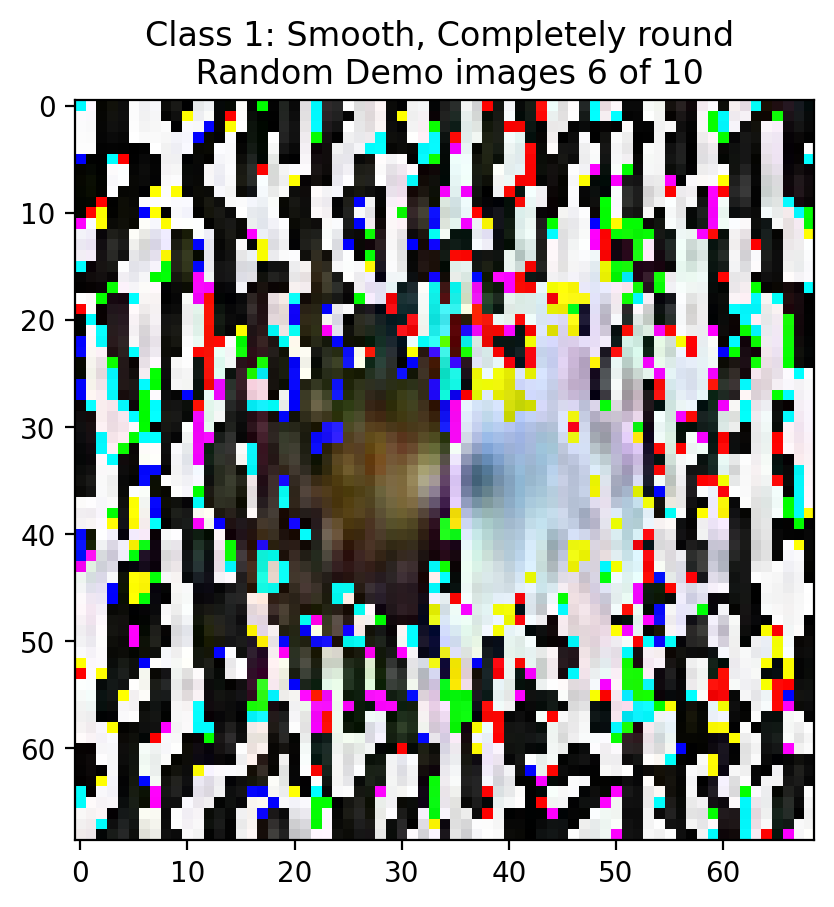

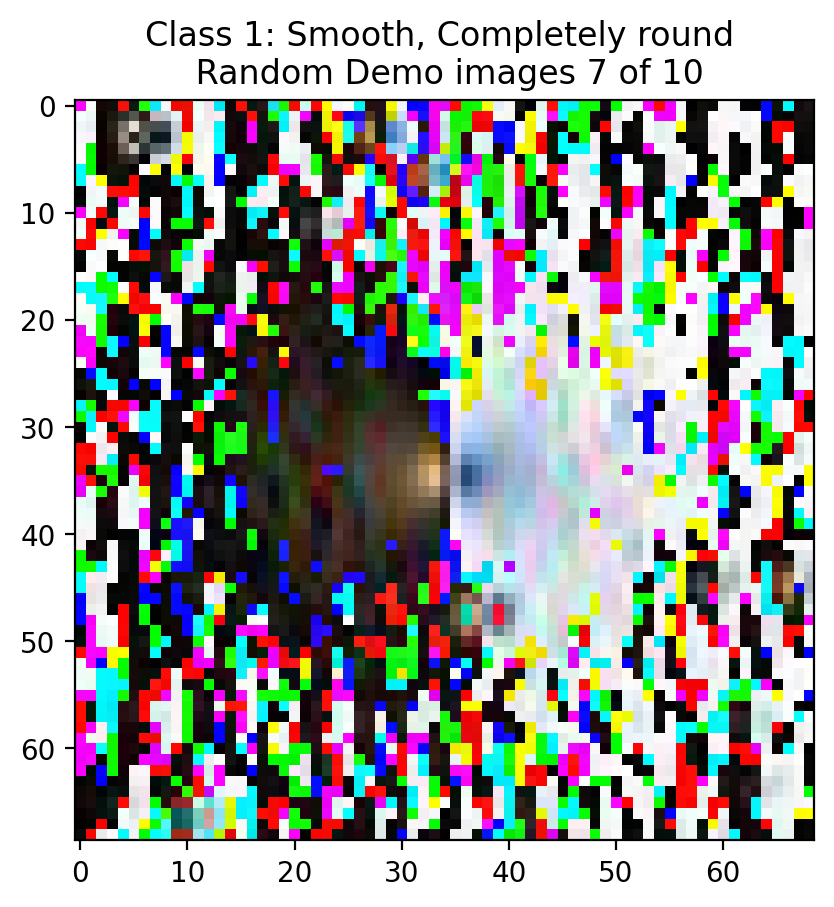

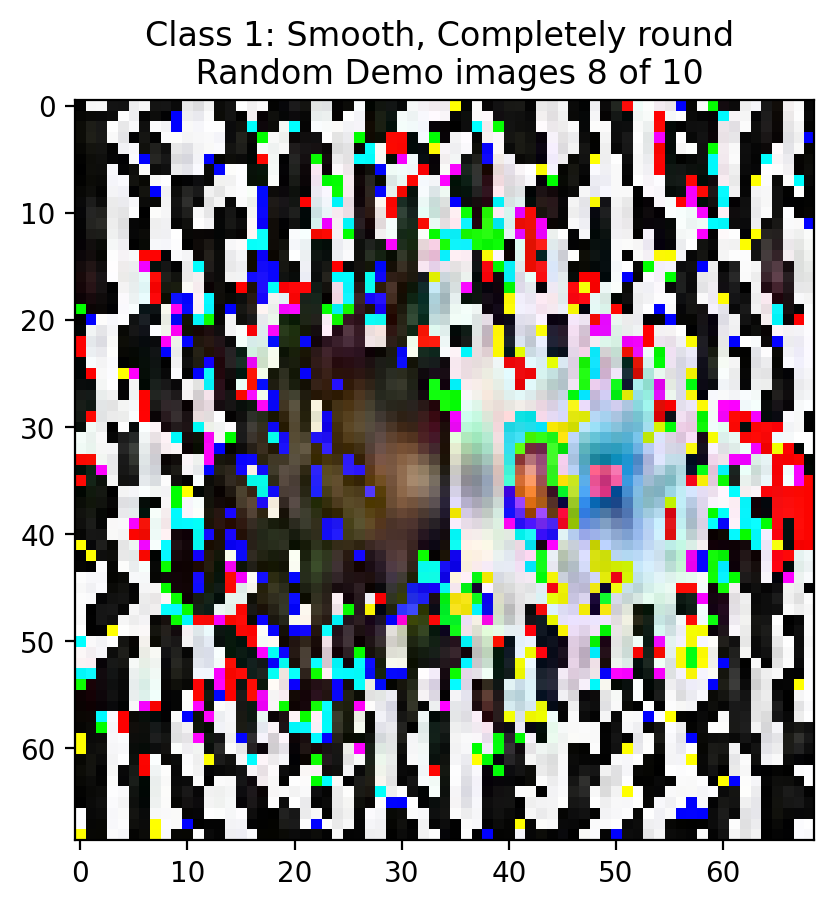

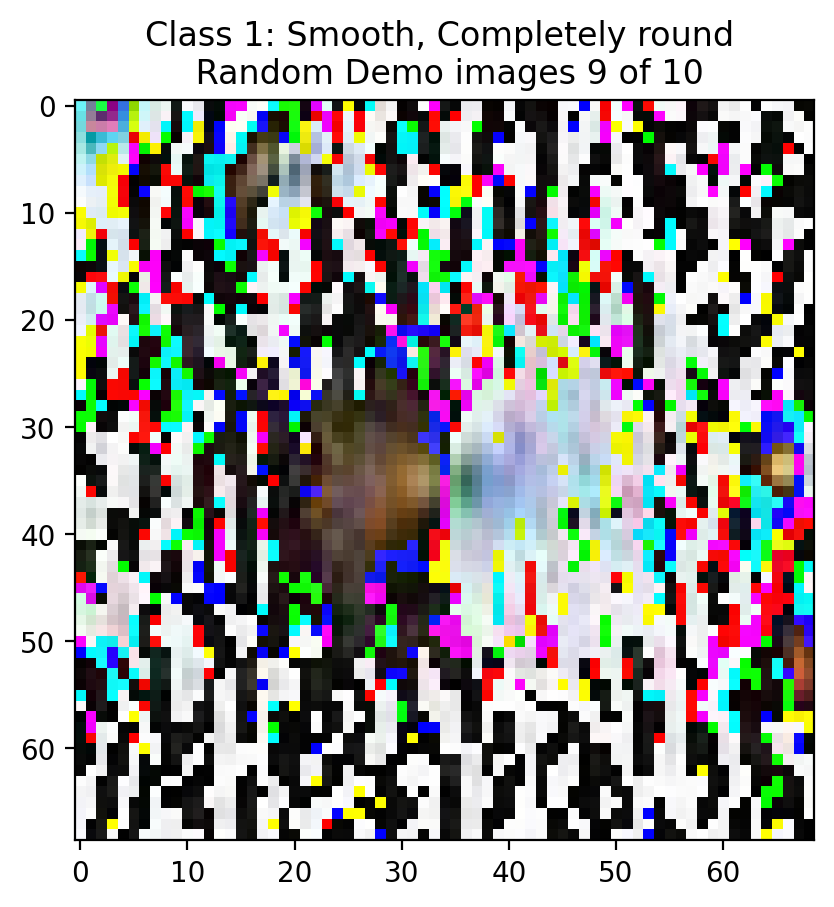

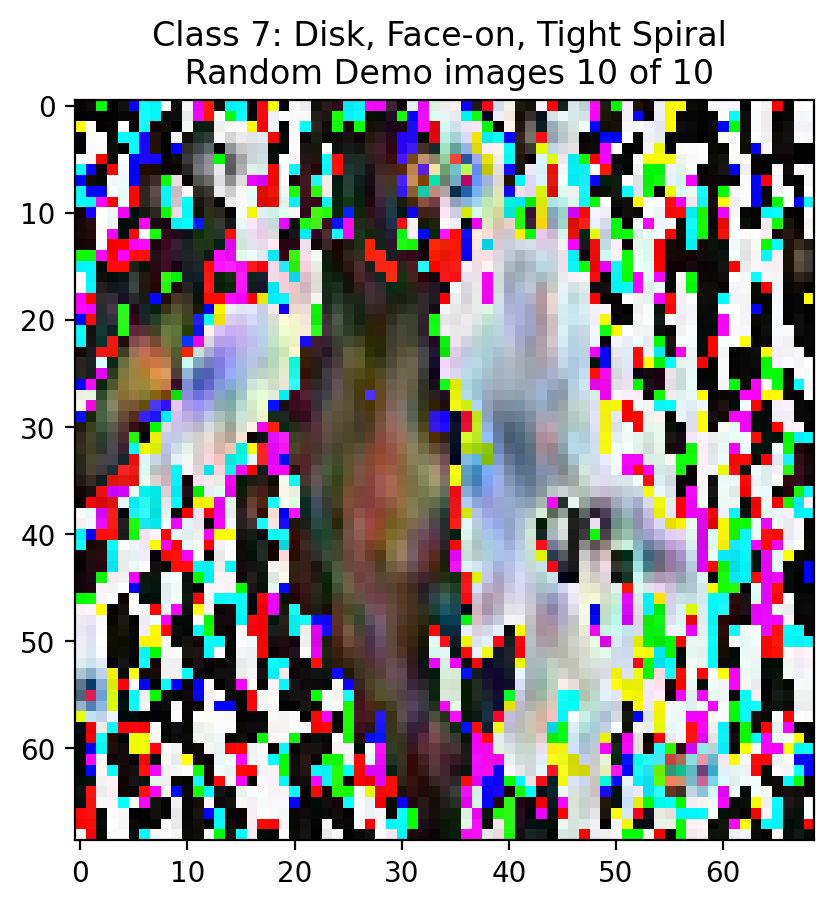

In [13]:
#Ahora las mismas imagenes las visualizamos con filtro
img = None
plt.ion()

for counter, i in enumerate(range(np.random.randint(0, labels.shape[0], size=10).shape[0])):
    img = plt.imshow(images[i])
    plt.title(f"Class {np.argmax(labels[i])}: {galaxy10cls_lookup(labels[i])} \n Random Demo images {counter+1} of 10")
    plt.draw()
    plt.pause(2.)
plt.close("all")

In [14]:
# Convertimos las etiquetas y las imagenes en números en formato que pueda ser leido
labels = labels.astype(np.float32)
images = images.astype(np.float32)

# Dividimos nuestros datos en datos de entrenamiento y en datos de prueba
train_idx, test_idx = train_test_split(np.arange(labels.shape[0]), test_size=0.1)
train_images, train_labels, test_images, test_labels = images[train_idx], labels[train_idx], images[test_idx], labels[test_idx]


In [15]:
epochs = 10
batch_size = 30

#num_train = n_files #numero de imagenes en train
#num_test =  n_files_test #numero de imagenes en test

#epoch_steps = num_train // batch_size
#test_steps = num_test // batch_size

In [16]:
#Creamos el modelo de capas que nuestra red va a tener para entrenarse, con capas convolucionales y max poolings
model = Sequential()
model.add(Conv2D(10, (3, 3), input_shape=(69, 69,3)))
model.add(Activation('relu'))
model.add(Conv2D(10, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(20, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('sigmoid'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 67, 67, 10)     │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 67, 67, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 65, 65, 10)     │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 65, 65, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 20)     │         1,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 30, 30, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 15, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,152,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,189,452 (4.54 MB)

 Trainable params: 1,189,452 (4.54 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
#Procedemos a entrenar, utilizando adam, ya que es el optimizador más eficiente para categorizar
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


history= model.fit(train_images, train_labels,
                  epochs=epochs,
                  validation_data=(test_images, test_labels))

## Un paso importante que realizo aquí es guardar nuestro modelo entrenado en un formato .h5, estoy probando
## para ver si lo puedo utilizar en otro codigo, cuando llame al modelo para poder visualizar la clasificacion
#model.save('Entrenado3.h5')


Epoch 1/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 125s 198ms/step - accuracy: 0.3549 - loss: 10.6480 - val_accuracy: 0.5682 - val_loss: 1.1421
Epoch 2/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 135s 187ms/step - accuracy: 0.5877 - loss: 1.1058 - val_accuracy: 0.6223 - val_loss: 0.9635
Epoch 3/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 144s 190ms/step - accuracy: 0.6600 - loss: 0.9129 - val_accuracy: 0.6714 - val_loss: 0.9162
Epoch 4/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 114s 186ms/step - accuracy: 0.7048 - loss: 0.7891 - val_accuracy: 0.6682 - val_loss: 0.9246
Epoch 5/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 143s 187ms/step - accuracy: 0.7486 - loss: 0.6748 - val_accuracy: 0.6728 - val_loss: 0.9283
Epoch 6/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 145s 192ms/step - accuracy: 0.7738 - loss: 0.6186 - val_accuracy: 0.6714 - val_loss: 0.9600
Epoch 7/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 146s 198ms/step - accuracy: 0.7992 - loss: 0.5381 - val_accuracy: 0.6641 - val_loss: 1.0085
Epoch 8/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 118s 192ms/step - accuracy: 0.8264 

In [ ]:
## Realizamos una prediccion
predicted_labels = model.predict(test_images)


prediction_class = np.argmax(predicted_labels, axis=1)

test_class = np.argmax(test_labels, axis=1)

69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step


In [22]:
def preprocess_image(img_path, target_size):
    img = image.load_img('/content/drive/MyDrive/Neuronal Networks Class/ClasificadorGalaxias/Imagenes/atareto1.jpg', target_size=(69,69))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalizar los píxeles de la imagen al rango [0, 1]
    return img_array

In [19]:
def classify_image(model, img_array, class_labels):
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    return class_labels[predicted_class[0]], predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
La imagen se clasifica como: Smooth, Completely round
Predicciones completas: [[0.6218917  0.7535434  0.6125494  0.3676253  0.56143373 0.35271633
  0.53103286 0.46014756 0.44511852 0.44713914]]


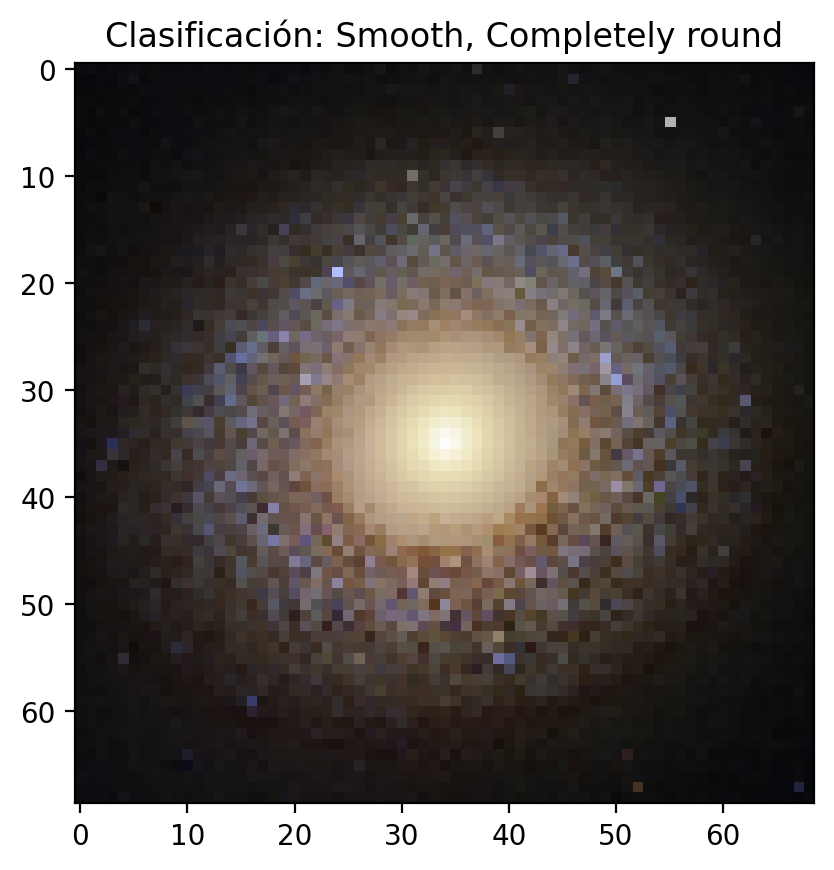

In [23]:
# Definir el tamaño de la imagen y las etiquetas de las clases
target_size = (69, 69)  # Ajusta este tamaño según el tamaño de las imágenes de entrenamiento
class_labels = ['Disk, Face-on, No Spiral', 'Smooth, Completely round', 'Smooth, in-between round',
                'Smooth, Cigar shaped', 'Disk, Edge-on, Rounded Bulge', 'Disk, Edge-on, Boxy Bulge',
                'Disk, Edge-on, No Bulge', 'Disk, Face-on, Tight Spiral', 'Disk, Face-on, Medium Spiral',
                'Disk, Face-on, Loose Spiral']  # Reemplaza con las etiquetas de tus clases

# Ruta de la imagen que deseas clasificar
img_path = '/content/drive/MyDrive/Neuronal Networks Class/ClasificadorGalaxias/Imagenes/atareto1.jpg'

# Preprocesar la imagen
img_array = preprocess_image(img_path, target_size)

# Realizar la predicción
predicted_class, predictions = classify_image(model, img_array, class_labels)

# Imprimir el resultado
print(f"La imagen se clasifica como: {predicted_class}")
print(f"Predicciones completas: {predictions}")

# Opcional: Mostrar la imagen
img = image.load_img(img_path, target_size=target_size)
plt.imshow(img)
plt.title(f"Clasificación: {predicted_class}")
plt.show()